# **Installation**

In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 9.5 MB/s eta 0:00:00


# **Libs**

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout
from keras.utils import to_categorical

import tensorflow_probability as tfp

import numpy as np
from numpy.random import sample
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

import sklearn
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_iris
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import BayesianRidge,LinearRegression
import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# tf.keras.backend.set_floatx('float64')

# **Data**

## **Data Generation**

In [ ]:
def gauss(A,mu,s,x):
  return A*(np.exp(-(x-mu)**2/(2*(s)**2)))

def line(m,c,x):
  return m*x+c

In [ ]:
N = 1000 #no. of curves
x = np.linspace(-10,10,N)

#Generating paramters from a normal disribution
np.random.seed(1234)
A =  3*np.random.normal(size=N)
A = A-np.min(A)
mu = 0.5*np.random.normal(size=N)
mu = mu-np.min(mu)
s = 0.4*np.random.normal(size=N)
s = s - np.min(s)
m = 25*np.random.normal(size=N)
m = m-np.min(m)
c = 250*np.random.normal(size=N)
c=c-np.min(c)

In [ ]:
# Creating 1000 gaussian function with different parameters
X_gauss = []
for i in range(N):
  X_gauss.append(gauss(A[i],mu[i],s[i],x))
X_gauss = np.asarray(X_gauss)
# Creating 1000 linear function with different parameters
X_line = []
for i in range(N):
  X_line.append(line(m[i],c[i],x))
X_line = np.asarray(X_line)

X_data = X_gauss + X_line
X_data = X_data
Y_data = np.array([A,mu,s,m,c]).T

Text(0.5, 1.0, 'Observed/Combined data')

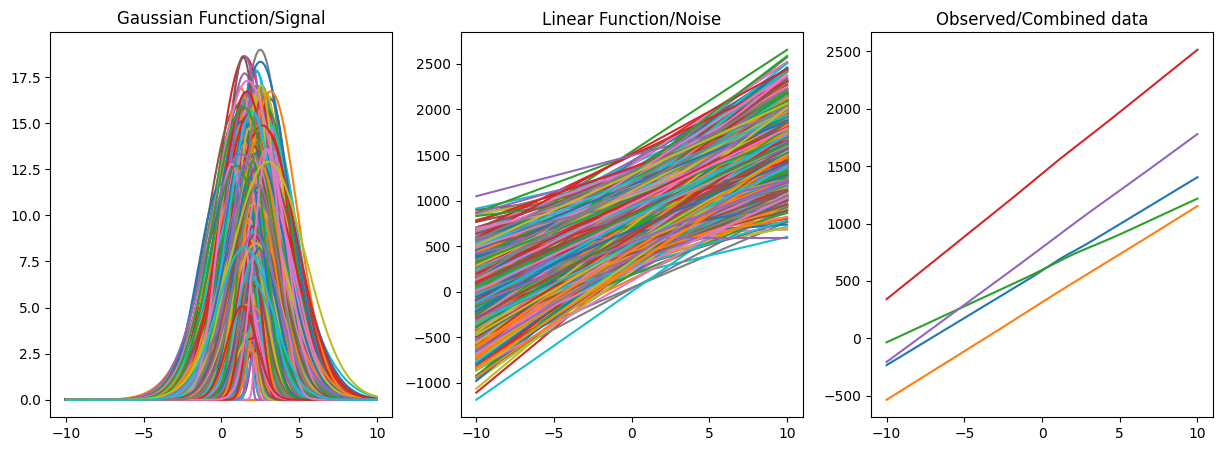

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i in range(N):
  ax[0].plot(x,X_gauss[i,:])
  ax[1].plot(x,X_line[i,:])

for i in range(5):
  ax[2].plot(x,X_data[i,:])

ax[0].set_title('Gaussian Function/Signal')
ax[1].set_title('Linear Function/Noise')
ax[2].set_title('Observed/Combined data')

## **Scaling**

In [ ]:
scaler_x =  StandardScaler()
scaler_x.fit(X_data)
X = scaler_x.transform(X_data)

scaler_y = StandardScaler()
scaler_y.fit(Y_data)
Y = scaler_y.transform(Y_data)

## **Data Split**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.1,random_state = 2)

In [ ]:
# x_train, y_train = shuffle(x_train, y_train, random_state=2)

# **Parameter Estimation**

## **Classical**

In [ ]:
def custom_loss(y_true, y_pred):
    # Define a weight to emphasize the Gaussian parameters (you can adjust this)
    weight_gaussian = 20.0

    # Split the true and predicted parameters into Gaussian and linear parts
    true_gaussian, true_linear = tf.split(y_true, [3, 2], axis=-1)
    pred_gaussian, pred_linear = tf.split(y_pred, [3, 2], axis=-1)

    # Compute mean squared error for Gaussian and linear parts separately
    mse_gaussian = tf.reduce_mean(tf.square(true_gaussian - pred_gaussian))
    mse_linear = tf.reduce_mean(tf.square(true_linear - pred_linear))

    # Combine the losses with the weight
    total_loss = mse_gaussian/weight_gaussian +  mse_linear

    return total_loss

In [ ]:
c_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(y_train.shape[1])  # Output layer with the same number of parameters
])

# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
c_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
# Define a neural network model with separate branches for Gaussian and linear parameters
input_layer = keras.layers.Input(shape=(x_train.shape[1],))

# Branch for Gaussian parameters
gaussian_branch = keras.layers.Dense(64, activation='relu')(input_layer)
gaussian_branch = keras.layers.Dense(64, activation='relu')(gaussian_branch)
gaussian_output = keras.layers.Dense(3)(gaussian_branch)

# Branch for linear parameters
linear_branch = keras.layers.Dense(64, activation='relu')(input_layer)
linear_branch = keras.layers.Dense(64, activation='relu')(linear_branch)
linear_output = keras.layers.Dense(2)(linear_branch)

# Combine both branches
combined_output = keras.layers.Concatenate()([gaussian_output, linear_output])

# Create the model
c_model = keras.models.Model(inputs=input_layer, outputs=combined_output)
# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
c_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
# Train the model
epochs = 1000  # Adjust as needed
batch_size = 256  # Adjust as needed
history = c_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,shuffle=True)

Epoch 1/1000
4/4 [==============================] - 4s 262ms/step - loss: 1.1796 - val_loss: 0.7842
Epoch 2/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.7552 - val_loss: 0.6718
Epoch 3/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.6801 - val_loss: 0.6224
Epoch 4/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.6396 - val_loss: 0.6510
Epoch 5/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.6425 - val_loss: 0.6325
Epoch 6/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.6400 - val_loss: 0.6384
Epoch 7/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.6359 - val_loss: 0.6115
Epoch 8/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.6256 - val_loss: 0.6309
Epoch 9/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.6264 - val_loss: 0.6337
Epoch 10/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.6588 - val_loss: 0.6096
Epoch 11

In [ ]:
c_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 64)                   64064     ['input_1[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 64)                   64064     ['input_1[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 64)                   4160      ['dense_5[0][0]']             
                                                                                              

In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

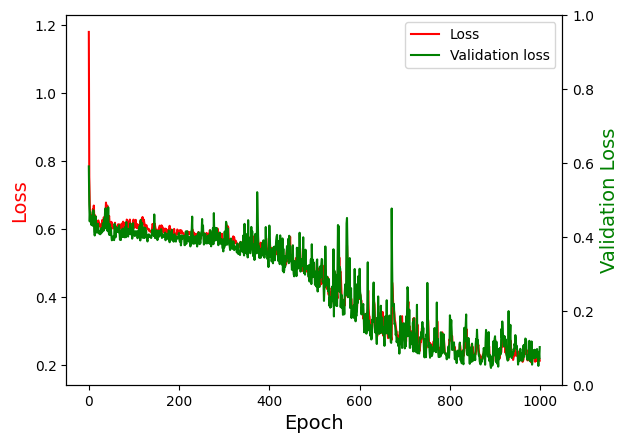

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = c_model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.2697


In [ ]:
# Compute the output

Y_pre = c_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)

Slope_r2score= r2_score(y_test[:,3], Y_pre[:,3])
print("Slope_R2score=",Slope_r2score )

Intercept_r2score= r2_score(y_test[:,4], Y_pre[:,4])
print("Intercept_R2score=",Intercept_r2score)

from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
slope_rmse= sqrt(mse[3])
Intcpt_rmse= sqrt(mse[4])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)
print("slope_RMSE=",slope_rmse)
print("Intcpt_RMSE=",Intcpt_rmse)




4/4 [==============================] - 0s 4ms/step
Amplitude_R2score= 0.6423494097457612
Mean_R2score= 0.7298167685126371
Std_Deviation_R2score= 0.17255991429553919
Slope_R2score= 0.9999785059097381
Intercept_R2score= 0.9999544770482135
Amplitude_RMSE= 0.6008066935561864
Mean_RMSE= 0.5241757839849726
Std_Deviation_RMSE= 0.8441006993690074
slope_RMSE= 0.004865513301274373
Intcpt_RMSE= 0.007258681759934933


In [ ]:
r2_score(y_test,Y_pre)

0.7089318151023778

[44 47 64 67 67  9 83 21 36 87]


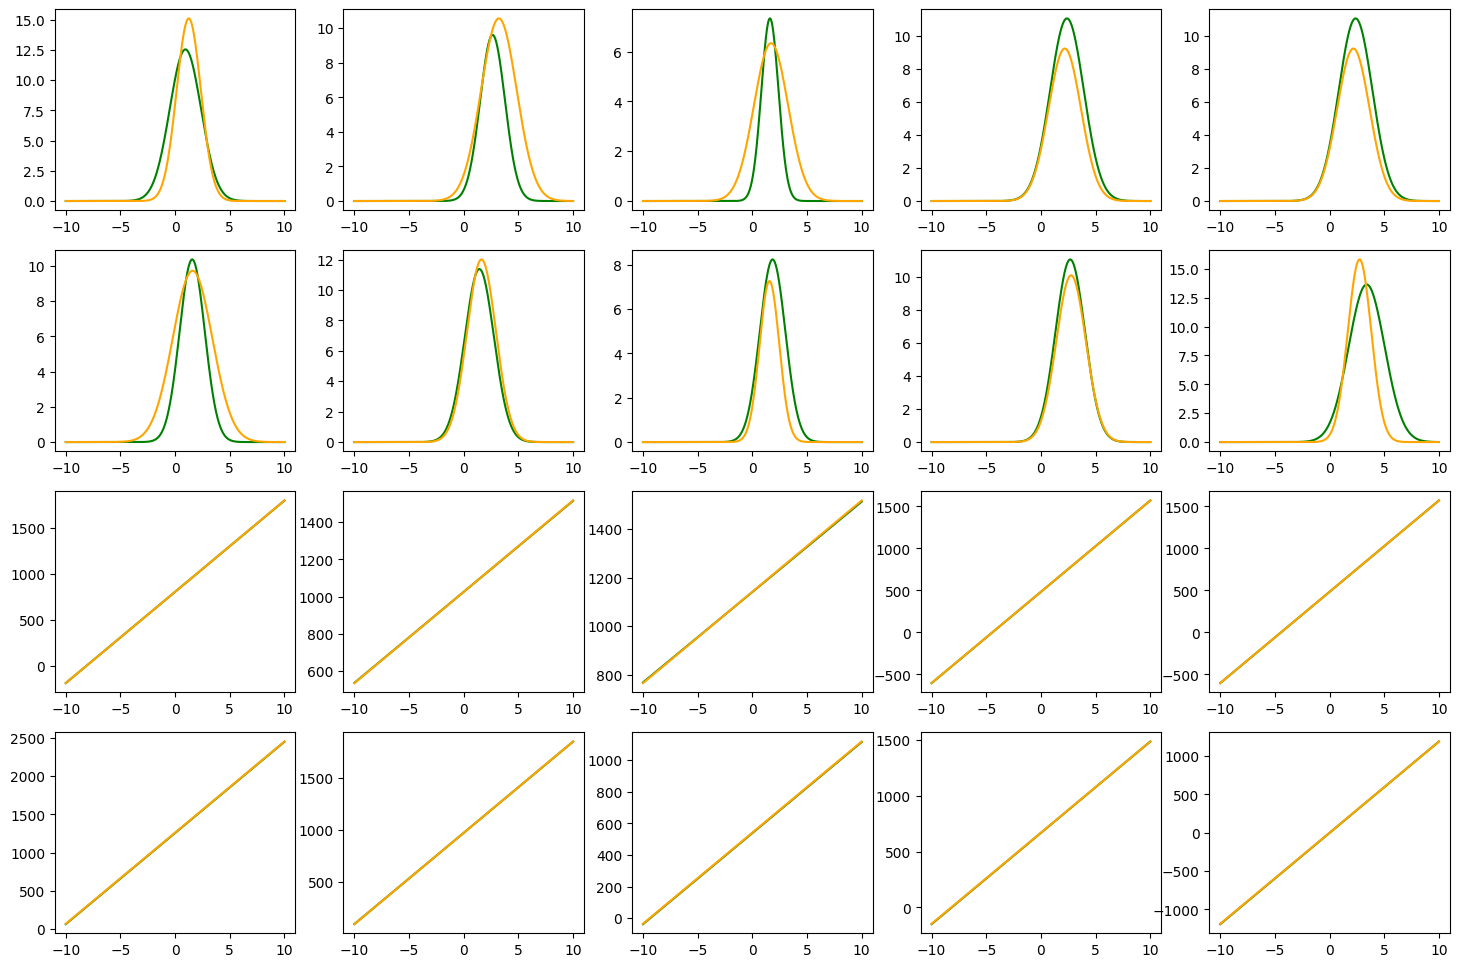

In [ ]:
np.random.seed(0)
fig,ax = plt.subplots(4,5,figsize=(18,12))
indx = np.random.randint(low=0,high=100,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z,w,u =Y_pred[ind[j]]
    h1,y1,z1,w1,u1 = Y_test[ind[j]]
    ax[i][j].plot(x,gauss(h,y,z,x),color='green')
    ax[i][j].plot(x,gauss(h1,y1,z1,x),color='orange')
    ax[i+2][j].plot(x,line(w,u,x),color='green')
    ax[i+2][j].plot(x,line(w1,u1,x),color='orange')

## **Bayesian 2.0**

In [ ]:
tfpd = tfp.distributions
tfpl = tfp.layers

In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfpl.DistributionLambda(
                lambda t: tfpd.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfpl.VariableLayer(
                tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfpl.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
# Create hidden layers with weight uncertainty using the DenseVariational layer.
inputs = keras.Input(shape=(x_train.shape[1],))
dense_1 = Dense(8,activation='relu')(inputs)
dense_2 = Dense(8,activation='relu')(dense_1)
# dense_var_1 = tfp.layers.DenseVariational(
#             8,
#             make_prior_fn=prior,
#             make_posterior_fn=posterior,
#             kl_weight=1 /x_train.shape[0],
#             activation="sigmoid",
#         )(inputs)
dense_var_1 = tfp.layers.DenseVariational(
            8,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1/x_train.shape[0],
            activation="relu",
        )(dense_2)

# The output is deterministic: a single point estimate.
out = Dense(5,activation='linear')(dense_var_1)
b_model = keras.Model(inputs=inputs,outputs=out)

In [ ]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
b_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
# Train the model
epochs = 2000  # Adjust as needed
batch_size = 256  # Adjust as needed
history = b_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,shuffle=True)

Epoch 1/2000
4/4 [==============================] - 4s 215ms/step - loss: 2.0721 - val_loss: 1.5356
Epoch 2/2000
4/4 [==============================] - 0s 24ms/step - loss: 4.0652 - val_loss: 1.3055
Epoch 3/2000
4/4 [==============================] - 0s 23ms/step - loss: 1.4917 - val_loss: 4.9161
Epoch 4/2000
4/4 [==============================] - 0s 25ms/step - loss: 1.7986 - val_loss: 3.7032
Epoch 5/2000
4/4 [==============================] - 0s 18ms/step - loss: 1.2268 - val_loss: 2.2513
Epoch 6/2000
4/4 [==============================] - 0s 24ms/step - loss: 1.4074 - val_loss: 1.7982
Epoch 7/2000
4/4 [==============================] - 0s 18ms/step - loss: 1.6180 - val_loss: 1.4878
Epoch 8/2000
4/4 [==============================] - 0s 18ms/step - loss: 1.5817 - val_loss: 1.1441
Epoch 9/2000
4/4 [==============================] - 0s 20ms/step - loss: 1.5716 - val_loss: 1.4274
Epoch 10/2000
4/4 [==============================] - 0s 18ms/step - loss: 1.3127 - val_loss: 2.2145
Epoch 11

In [ ]:
b_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_11 (Dense)            (None, 8)                 8008      
                                                                 
 dense_12 (Dense)            (None, 8)                 72        
                                                                 
 dense_variational (DenseVa  (None, 8)                 2700      
 riational)                                                      
                                                                 
 dense_13 (Dense)            (None, 5)                 45        
                                                                 
Total params: 10825 (42.29 KB)
Trainable params: 10825 (42.29 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

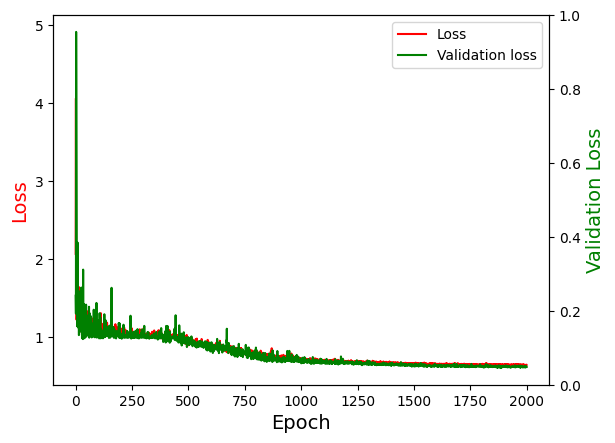

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = b_model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.6316


In [ ]:
# Compute the output

Y_pre = b_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)

Slope_r2score= r2_score(y_test[:,3], Y_pre[:,3])
print("Slope_R2score=",Slope_r2score )

Intercept_r2score= r2_score(y_test[:,4], Y_pre[:,4])
print("Intercept_R2score=",Intercept_r2score)

from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
slope_rmse= sqrt(mse[3])
Intcpt_rmse= sqrt(mse[4])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)
print("slope_RMSE=",slope_rmse)
print("Intcpt_RMSE=",Intcpt_rmse)

4/4 [==============================] - 0s 4ms/step
Amplitude_R2score= -0.006360535164756431
Mean_R2score= -0.01565252990096999
Std_Deviation_R2score= -0.005169604344219536
Slope_R2score= 0.9499176949685912
Intercept_R2score= 0.9649703822428015
Amplitude_RMSE= 1.0078179474736813
Mean_RMSE= 1.0162962776198892
Std_Deviation_RMSE= 0.9303484864782597
slope_RMSE= 0.23486120485347678
Intcpt_RMSE= 0.20135399373553156


In [ ]:
r2_score(y_test,Y_pre)

0.37754108156028926

[44 47 64 67 67  9 83 21 36 87]


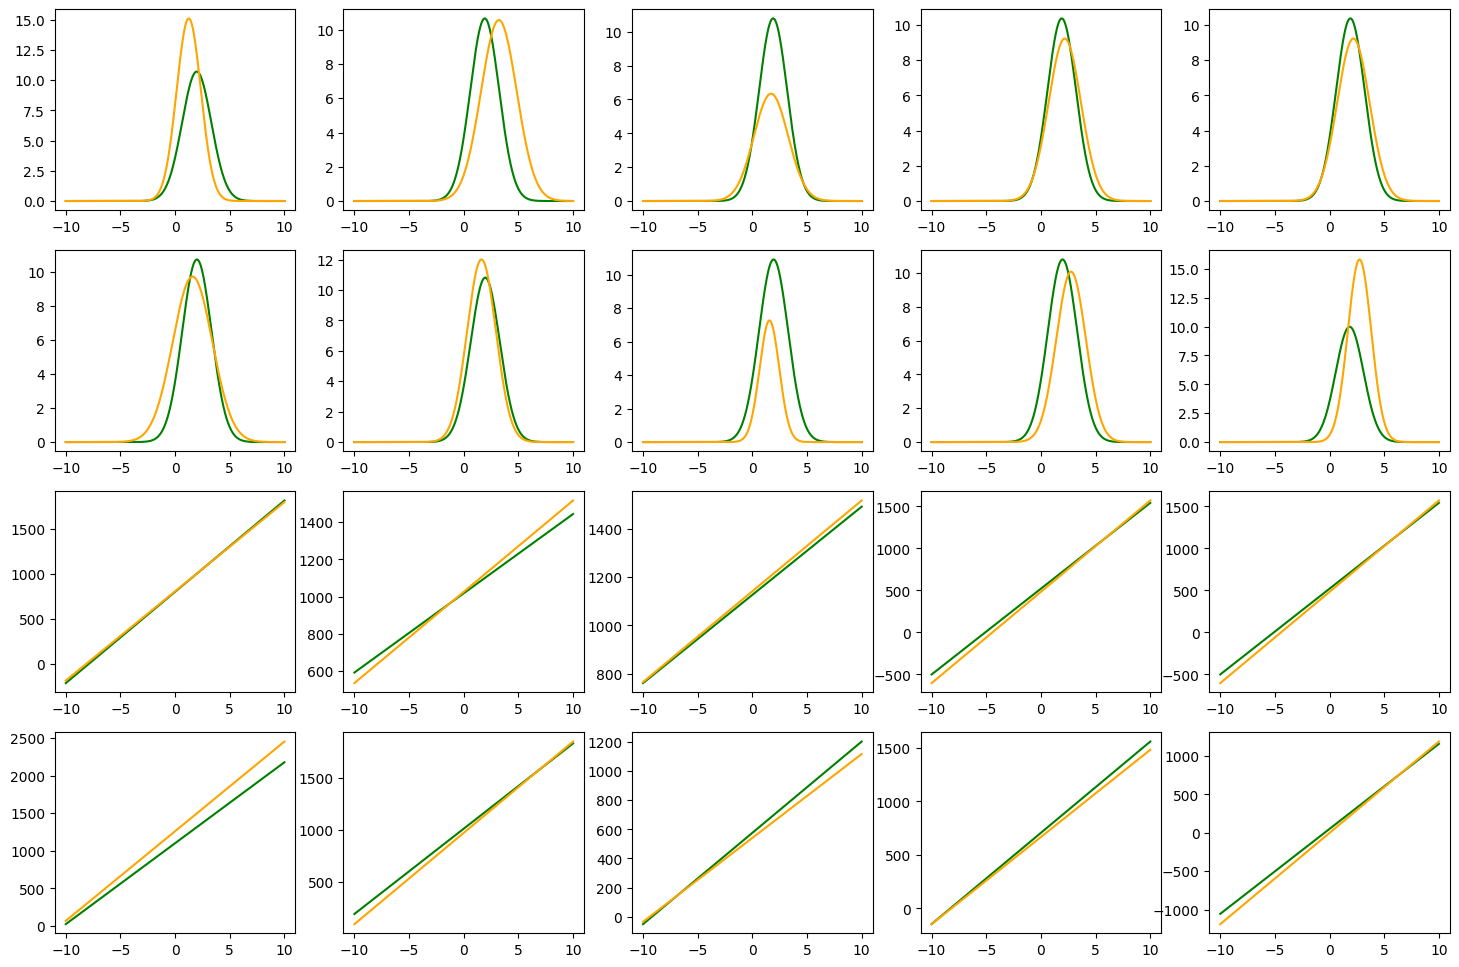

In [ ]:
np.random.seed(0)
fig,ax = plt.subplots(4,5,figsize=(18,12))
indx = np.random.randint(low=0,high=100,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z,w,u =Y_pred[ind[j]]
    h1,y1,z1,w1,u1 = Y_test[ind[j]]
    ax[i][j].plot(x,gauss(h,y,z,x),color='green')
    ax[i][j].plot(x,gauss(h1,y1,z1,x),color='orange')
    ax[i+2][j].plot(x,line(w,u,x),color='green')
    ax[i+2][j].plot(x,line(w1,u1,x),color='orange')

## **Hybrid-Quantum**

In [ ]:
n_qubits = 5
layers = 4

dev = qml.device("default.qubit", wires=n_qubits)
# tf.keras.backend.set_floatx('float64')

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    # qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    # qml.RandomLayers(weights,wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
weight_shapes = {"weights": (layers, n_qubits,3)}
weight_specs = {"weights": {"initializer": "random_uniform"}}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, weight_specs = weight_specs, output_dim=n_qubits)
# clayer1 = Dense(32, activation='relu',input_shape=(x_train.shape[1],))
# clayer2 = Dense(64,activation='relu')
clayer3 = Dense(n_qubits,activation='relu',input_shape=(x_train.shape[1],))
clayer4 = Dense(n_qubits,activation='relu')
clayer5 = Dense(y_train.shape[1],activation='linear')
hq_model = keras.Sequential([clayer3,qlayer,clayer4,clayer5])

In [ ]:

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=5,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=20,
)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
hq_model.compile(opt, loss='mean_squared_error')

In [ ]:
history = hq_model.fit(x_train, y_train, epochs=100, batch_size=128,validation_split=0.1,verbose=1,callbacks=[callback],shuffle=True)


Epoch 1/100
7/7 [==============================] - 9s 1s/step - loss: 1.0393 - val_loss: 0.9888
Epoch 2/100
7/7 [==============================] - 4s 597ms/step - loss: 0.9771 - val_loss: 0.9048
Epoch 3/100
7/7 [==============================] - 4s 587ms/step - loss: 0.9206 - val_loss: 0.8734
Epoch 4/100
7/7 [==============================] - 5s 700ms/step - loss: 0.9080 - val_loss: 0.8948
Epoch 5/100
7/7 [==============================] - 4s 583ms/step - loss: 0.8892 - val_loss: 0.8687
Epoch 6/100
7/7 [==============================] - 5s 685ms/step - loss: 0.8974 - val_loss: 0.8492
Epoch 7/100
7/7 [==============================] - 5s 647ms/step - loss: 0.8896 - val_loss: 0.8727
Epoch 8/100
7/7 [==============================] - 4s 579ms/step - loss: 0.8697 - val_loss: 0.8644
Epoch 9/100
7/7 [==============================] - 5s 669ms/step - loss: 0.8718 - val_loss: 0.8220
Epoch 10/100
7/7 [==============================] - 5s 606ms/step - loss: 0.8652 - val_loss: 0.8468
Epoch 11/100

In [ ]:
hq_model.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 5)                 5005      
                                                                 
 keras_layer_13 (KerasLayer  (None, 5)                 60        
 )                                                               
                                                                 
 dense_44 (Dense)            (None, 5)                 30        
                                                                 
 dense_45 (Dense)            (None, 5)                 30        
                                                                 
Total params: 5125 (20.02 KB)
Trainable params: 5125 (20.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

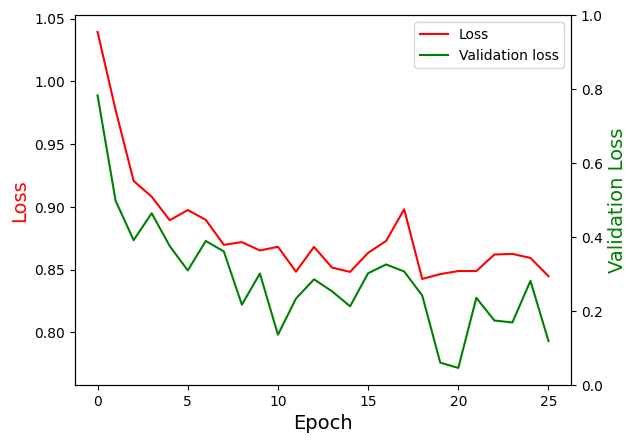

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = hq_model.evaluate(x_test,y_test)

4/4 [==============================] - 1s 334ms/step - loss: 0.8462


In [ ]:
# Compute the output

Y_pre = hq_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)

Slope_r2score= r2_score(y_test[:,3], Y_pre[:,3])
print("Slope_R2score=",Slope_r2score )

Intercept_r2score= r2_score(y_test[:,4], Y_pre[:,4])
print("Intercept_R2score=",Intercept_r2score)

from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
slope_rmse= sqrt(mse[3])
Intcpt_rmse= sqrt(mse[4])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)
print("slope_RMSE=",slope_rmse)
print("Intcpt_RMSE=",Intcpt_rmse)

4/4 [==============================] - 1s 338ms/step
Amplitude_R2score= 0.007969640612438211
Mean_R2score= 0.007194442372589038
Std_Deviation_R2score= -0.007673947849381468
Slope_R2score= 0.3831716199354661
Intercept_R2score= 0.41863503744686403
Amplitude_RMSE= 1.0006167556518066
Mean_RMSE= 1.0048005344440905
Std_Deviation_RMSE= 0.9315067302023748
slope_RMSE= 0.8242354769992328
Intcpt_RMSE= 0.820289166727112


In [ ]:
r2_score(y_test,Y_pre)

0.16185935850359512

[44 47 64 67 67  9 83 21 36 87]


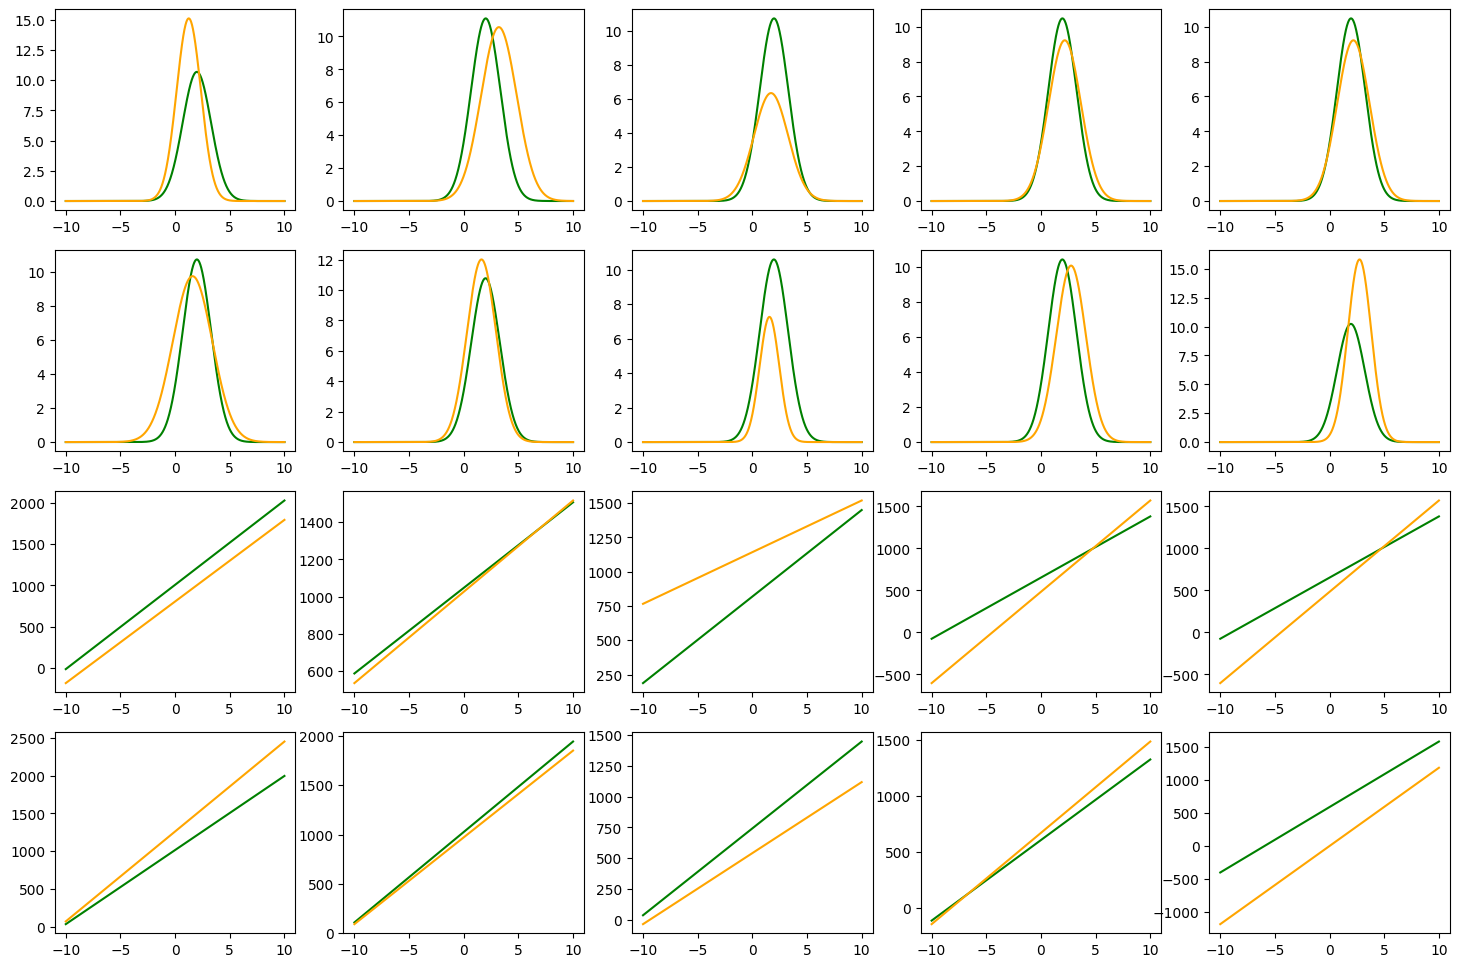

In [ ]:
np.random.seed(0)
fig,ax = plt.subplots(4,5,figsize=(18,12))
indx = np.random.randint(low=0,high=100,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z,w,u =Y_pred[ind[j]]
    h1,y1,z1,w1,u1 = Y_test[ind[j]]
    ax[i][j].plot(x,gauss(h,y,z,x),color='green')
    ax[i][j].plot(x,gauss(h1,y1,z1,x),color='orange')
    ax[i+2][j].plot(x,line(w,u,x),color='green')
    ax[i+2][j].plot(x,line(w1,u1,x),color='orange')